# Principal Component Analysis (PCA)

## Imports

In [1]:
# %matplotlib notebook
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Load the MNIST dataset.
data = sio.loadmat('mnist_digits.mat')

In [3]:
X = data['x']
Y = data['y']
n, dim = X.shape
print(f'The dataset has {n} examples of dimension {dim}.')

# Select only the digits in `digits`.
digits = [1, 9]  # 1 and 9 are cherry picked.
# digits = list(range(10))
indices = []
for digit in range(10):
    indices.append(np.argwhere(Y == digit)[:, 0])

X = np.concatenate([X[indices[digit]] for digit in digits], axis=0)
Y = np.concatenate([Y[indices[digit]] for digit in digits], axis=0)

indices = []
for digit in range(10):
    indices.append(np.argwhere(Y == digit)[:, 0])

n, dim = X.shape
print(f'The trimmed down dataset has {n} examples of dimension {dim}.')

# Add noise to the data.
sigma = 0.1
noisy_X = X + sigma * np.random.randn(*X.shape)

The dataset has 66000 examples of dimension 784.
The trimmed down dataset has 13998 examples of dimension 784.


## PCA

In [4]:
def pca(X, d=1, plot=False, label=''):
    # Assert that the data is centered.
    mean = np.mean(X)
    X_centered = np.array([x - mean for x in X])
    
    # Compute the eigenvectors and eigenvalues.
    eig_val, eig_vect = np.linalg.eig(X_centered.T @ X_centered)
    # Remove the imaginary part.
    eig_val = np.real(eig_val)
    eig_vect = np.real(eig_vect)
    
    # Sort by eigen value.
    sort_idx = np.argsort(eig_val)
    sorted_eig_val = eig_val[sort_idx]
    sorted_eig_vect = eig_vect[sort_idx]
    
    # Plot the eigenvalues.
    if plot:
        plt.plot(np.maximum(sorted_eig_val, 10 ** (-11)), label=label)
        plt.yscale('log')

    # Compute the projection on the subspace.
    sub_space = sorted_eig_vect[-d:]
    Z = np.array([np.array([np.dot(v, x) for v in sub_space]) for x in X_centered])
    
    return np.array([z + mean for z in Z])

### 1D

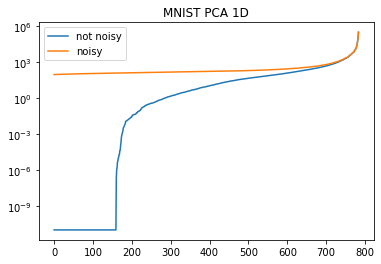

In [5]:
Z = np.sort(pca(X, plot=True, label='not noisy'), axis=None)
noisy_Z = np.sort(pca(noisy_X, plot=True, label='noisy'), axis=None)
plt.title('MNIST PCA 1D')
plt.legend()
plt.show()

### 2D

In [6]:
def show_2d_pca(X, nb_points=100):
    Z = pca(X, d=2)
    for digit in digits:
        Z_digit = Z[indices[digit]][:nb_points]
        plt.scatter(Z_digit[:, 0], Z_digit[:, 1], label=f'{digit}')

    plt.title('MNIST PCA 2D')
    plt.legend()
    plt.show()

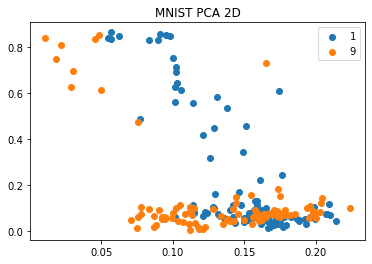

In [7]:
show_2d_pca(X)

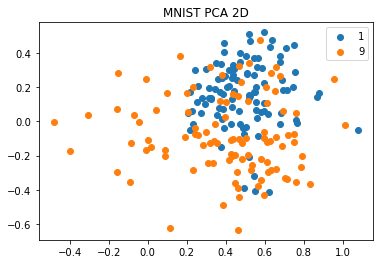

In [8]:
show_2d_pca(noisy_X)

### 3D

In [9]:
def show_3d_pca(X, nb_points=100):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    Z = pca(X, d=3)
    for digit in digits:
        Z_digit = Z[indices[digit]][:nb_points]
        ax.scatter(Z_digit[:, 0], Z_digit[:, 1], Z_digit[:, 2], label=f'{digit}')

    plt.title('MNIST PCA 3D')
    plt.legend()
    plt.show()

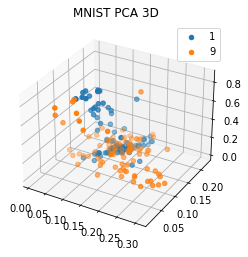

In [10]:
show_3d_pca(X)

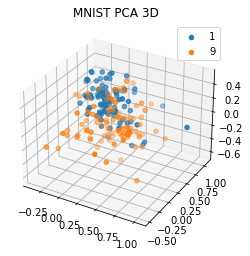

In [11]:
show_3d_pca(noisy_X)

## OLS

In [12]:
def ols(X):
    X_powers = np.array([np.array([1, *x]) for x in X], dtype=np.float64)
    theta = np.linalg.lstsq(X, Y, rcond=None)[0]
    return theta

In [13]:
d = 30

# Not noisy.
Z = pca(X, d=d)

theta_ref = ols(X)
theta_pca = ols(Z)

# Noisy.
noisy_Z = pca(noisy_X, d=d)

noisy_theta_ref = ols(noisy_X)
noisy_theta_pca = ols(noisy_Z)

In [14]:
Y_pca = np.array([np.dot(theta_pca.T, z) for z in Z])
Y_ref = np.array([np.dot(theta_ref.T, x) for x in X])

noisy_Y_pca = np.array([np.dot(noisy_theta_pca.T, z) for z in noisy_Z])
noisy_Y_ref = np.array([np.dot(noisy_theta_ref.T, x) for x in noisy_X])

In [15]:
def show_Y(Y, digits, title=''):
    for digit in digits:
        ys = np.sort(Y[indices[digit]], axis=None)
        plt.plot(ys, label=f'{digit}')
        
    plt.title(title)
    plt.legend()
    plt.show()

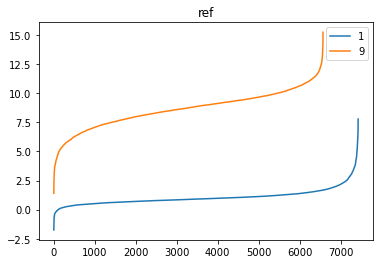

In [16]:
show_Y(Y_ref, digits, 'ref')

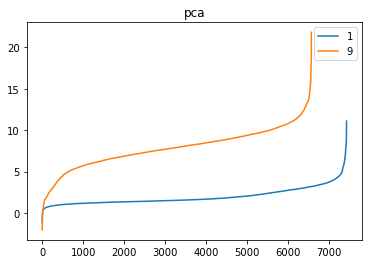

In [17]:
show_Y(Y_pca, digits, 'pca')

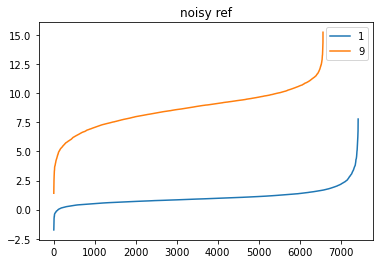

In [18]:
show_Y(Y_ref, digits, 'noisy ref')

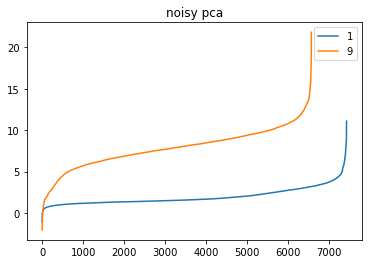

In [19]:
show_Y(Y_pca, digits, 'noisy pca')

In [20]:
def error(Y, y1, y2, threshold):
    n = len(indices[y1]) + len(indices[y2])
    return (np.sum(Y[indices[y1]] >= threshold) + np.sum(Y[indices[y2]] < threshold)) / n

In [21]:
y1 = 1
y2 = 9

### Optimize the thresholds by linear search

In [22]:
Ys = [('ref', Y_ref), ('pca', Y_pca), ('noisy ref', noisy_Y_ref), ('noisy pca', noisy_Y_pca)]

print('error\tthreshold\tname\n' + '-' * 28)
for Y_name, Y in Ys:
    # -5 and 25 shouldn't be hardcoded :(
    e, t = min([(error(Y, y1, y2, threshold), threshold) for threshold in np.linspace(-5, 25, 10 ** 5)])
    print(f'{e * 100:.2f}%\t{t:.2f}\t\t{Y_name}')

error	threshold	name
----------------------------
0.72%	3.92		ref
4.79%	4.29		pca
0.95%	3.71		noisy ref
3.16%	4.42		noisy pca


# TODO
- plot the error as a function of d
- refactor
- polynomial regression
- test data
- study the impact of the noise
- does dimention reduction prevent overfitting?
- remove for loops and use vectorization instead